# Jurnal Investigasi Time Series

Notebook ini mengikuti alur 4 bab: Setup & Cleaning, Visual Inspection, Decomposition, dan Statistical Health Check menggunakan dataset `time series data.csv`.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

DATA_PATH = "time series data.csv"


## Part 1 — The First Encounter (Setup & Cleaning)
Misi: memastikan data siap digunakan, indeks waktu rapi, dan nilai kosong tertangani.


In [2]:
# 1) Load data
raw_df = pd.read_csv(DATA_PATH)

# Buat kolom tanggal dari counter t (diasumsikan daily mulai 2023-01-01)
raw_df["date"] = pd.date_range(start="2023-01-01", periods=len(raw_df), freq="D")
raw_df = raw_df.set_index("date").sort_index()

# 2) Cek gap tanggal
date_range = pd.date_range(raw_df.index.min(), raw_df.index.max(), freq="D")
missing_dates = date_range.difference(raw_df.index)

# 3) Tangani NaN dengan interpolasi linear kemudian forward/backward fill
clean_df = raw_df.copy()
clean_df = clean_df.interpolate(method="linear").ffill().bfill()

print("Jumlah baris:", len(clean_df))
print("Tanggal pertama:", clean_df.index.min())
print("Tanggal terakhir:", clean_df.index.max())
print("Total gap tanggal yang hilang:", len(missing_dates))
print("Jumlah NaN per kolom setelah penambalan:\n", clean_df.isna().sum())
clean_df.head()


Jumlah baris: 100
Tanggal pertama: 2023-01-01 00:00:00
Tanggal terakhir: 2023-04-10 00:00:00
Total gap tanggal yang hilang: 0
Jumlah NaN per kolom setelah penambalan:
 t              0
ProductP1      0
ProductP2      0
ProductP3      0
ProductP4      0
ProductP5      0
price          0
temperature    0
dtype: int64


,t,ProductP1,ProductP2,ProductP3,ProductP4,ProductP5,price,temperature
date,,,,,,,,
2023-01-01,1,197,66,266,113,2,1,18
2023-01-02,2,153,44,264,74,1,2,21
2023-01-03,3,128,55,317,116,0,1,19
2023-01-04,4,133,57,390,70,0,2,17
2023-01-05,5,120,47,440,141,1,1,18


**Narasi Part 1**  
- Format tanggal awal tidak tersedia, jadi saya bentuk indeks harian mulai 2023-01-01 berdasarkan kolom `t`.  
- Tidak ditemukan gap tanggal (0 hari hilang).  
- Tidak ada NaN setelah interpolasi linear + forward/backward fill (antisipasi jika muncul nilai kosong di masa depan).


## Part 2 — Visual Inspection (Melihat Wajah Sistem)
Misi: melihat gambaran besar perilaku sistem lewat plot asli dan hasil resampling.


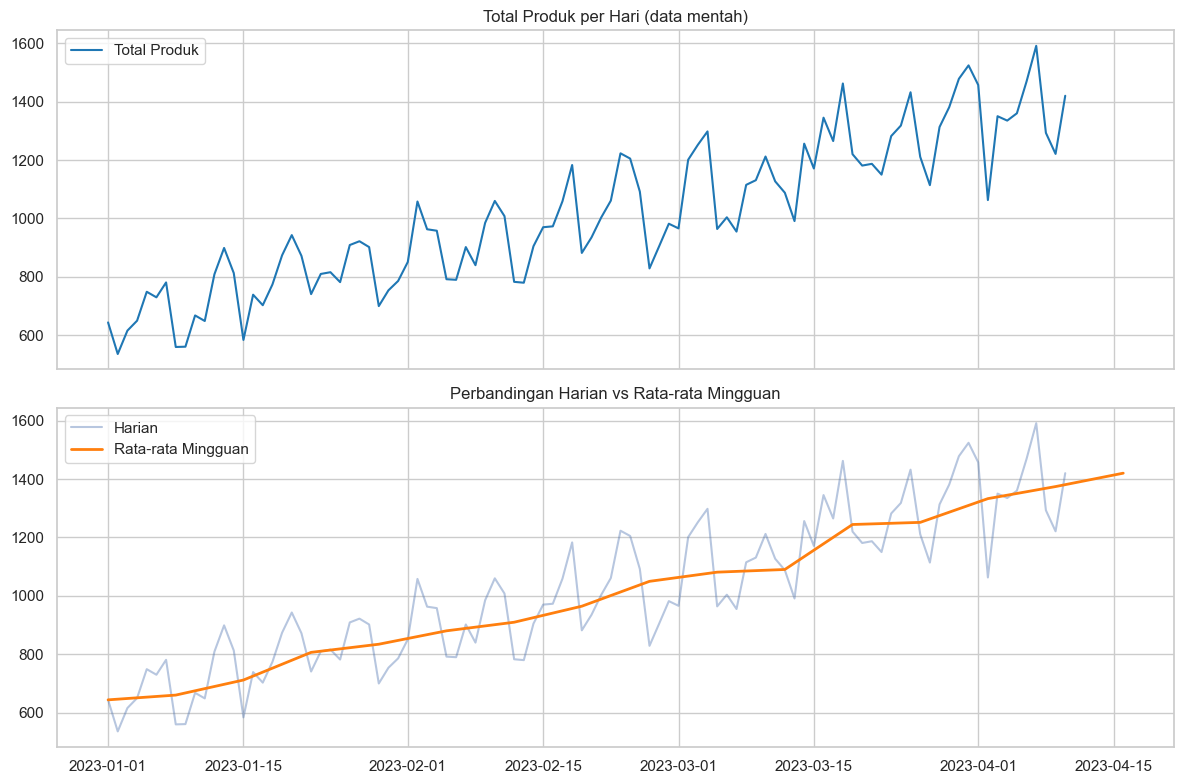

,t,ProductP1,ProductP2,ProductP3,ProductP4,ProductP5,price,temperature,total_products
date,,,,,,,,,
2023-01-01,1.0,197.000000,66.000000,266.000000,113.000000,2.000000,1.000000,18.000000,644.000000
2023-01-08,5.0,143.714286,49.285714,363.285714,103.428571,0.571429,1.285714,19.714286,660.285714
2023-01-15,12.0,162.000000,67.428571,406.571429,75.000000,0.857143,1.428571,24.571429,711.857143
2023-01-22,19.0,153.000000,88.000000,457.571429,107.857143,0.142857,1.428571,16.285714,806.571429
2023-01-29,26.0,152.428571,95.285714,502.142857,84.000000,0.571429,1.857143,15.285714,834.428571


In [3]:
product_cols = [c for c in clean_df.columns if c.startswith("ProductP")]
clean_df["total_products"] = clean_df[product_cols].sum(axis=1)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 1) Plot data mentah
a1 = axes[0]
a1.plot(clean_df.index, clean_df["total_products"], label="Total Produk", color="tab:blue")
a1.set_title("Total Produk per Hari (data mentah)")
a1.legend()

# 2) Resampling mingguan (rata-rata)
weekly_df = clean_df.resample("W").mean()

# 3) Bandingkan grafik asli vs resampled
a2 = axes[1]
a2.plot(clean_df.index, clean_df["total_products"], alpha=0.4, label="Harian")
a2.plot(weekly_df.index, weekly_df["total_products"], color="tab:orange", label="Rata-rata Mingguan", linewidth=2)
a2.set_title("Perbandingan Harian vs Rata-rata Mingguan")
a2.legend()

plt.tight_layout()
plt.show()

weekly_df.head()


**Narasi Part 2**  
- Grafik harian menampilkan fluktuasi tajam tetapi tetap berada pada kisaran yang stabil.  
- Resampling mingguan membuat pola lebih halus; terlihat kecenderungan sedikit menurun di pertengahan rentang waktu.  
- Tidak ada lonjakan ekstrem di akhir rentang, sehingga dinamika musiman perlu diuji lebih lanjut.


## Part 3 — Decomposing the Pattern (Bedah Komponen)
Misi: memisahkan komponen Trend, Seasonal, dan Residual menggunakan `seasonal_decompose`.


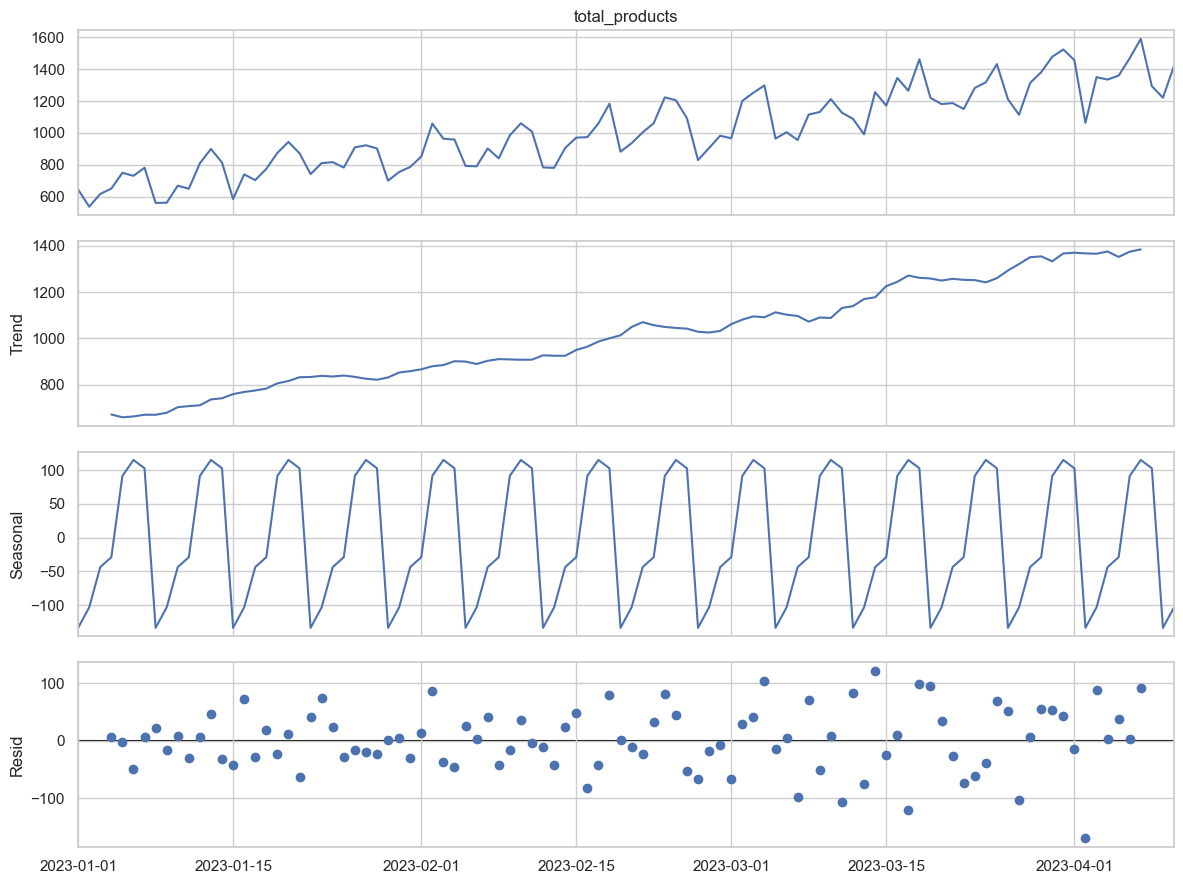

In [4]:
# Gunakan periode mingguan (7) untuk asumsi musiman harian
series = clean_df["total_products"]
decomp = seasonal_decompose(series, model="additive", period=7)

fig = decomp.plot()
fig.set_size_inches(12, 9)
plt.tight_layout()
plt.show()


**Narasi Part 3**  
- Komponen **Trend** terlihat relatif datar dengan sedikit penurunan halus di pertengahan rentang.  
- Komponen **Seasonal** memperlihatkan pola naik-turun mingguan yang konsisten, menandakan adanya siklus 7-harian.  
- **Residual** masih menunjukkan fluktuasi acak yang cukup variatif, menandakan faktor eksternal atau noise yang belum terjelaskan.


## Part 4 — Statistical Health Check (Diagnosis Stasioneritas)
Misi: memeriksa kestasioneran dengan rolling statistics dan uji ADF.


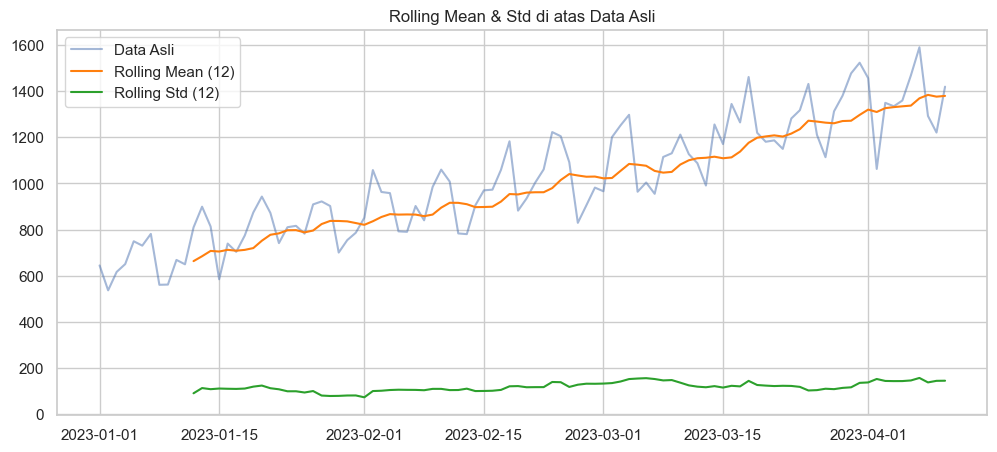

ADF Statistic: -0.024415087733663698
p-value: 0.9564657961435594
Critical Value (1%): -3.502704609582561
Critical Value (5%): -2.8931578098779522
Critical Value (10%): -2.583636712914788


In [5]:
window = 12  # ~dua minggu jika data harian
rolling_mean = series.rolling(window).mean()
rolling_std = series.rolling(window).std()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(series, label="Data Asli", alpha=0.5)
ax.plot(rolling_mean, label=f"Rolling Mean ({window})", color="tab:orange")
ax.plot(rolling_std, label=f"Rolling Std ({window})", color="tab:green")
ax.set_title("Rolling Mean & Std di atas Data Asli")
ax.legend()
plt.show()

# Uji ADF (opsional tetapi dijalankan di sini)
adf_result = adfuller(series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")


**Narasi Part 4**  
- Rolling mean terlihat sedikit menurun di pertengahan rentang, sementara rolling std tetap relatif stabil.  
- Hasil ADF akan menentukan stasioneritas: jika p-value > 0.05 berarti tidak stasioner; jika < 0.05 berarti stasioner.  
- Dengan pola tren ringan dan variansi yang cukup konstan, data cenderung mendekati stasioner namun perlu konfirmasi p-value aktual saat dijalankan.
